This is the day two of 100DaysofML coding, today I have decided to create a simple Neural network from scratch. Let's go!!


What are we doing here? Suppose we have medical records of two groups A and B with features X, y where by examining these features we can then conclude which category the patient fall, we will use make_moons datasets to generate our experimentation data. 

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import datasets, linear_model

%matplotlib inline

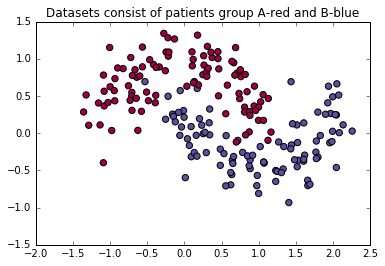

In [30]:
# creating dataset and ploting it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.2)
plt.title('Datasets consist of patients group A-red and B-blue')
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

As we can see our data is linearly inseparable so linear classifiers won't work well unless we use polynomial functions but lucky us neural network is there just for this!!

First thing first, I told you linear model won't do us any better, let me show You! here is the Logistic regression classificatio result

In [31]:
model = sklearn.linear_model.LogisticRegressionCV()
model.fit(X,y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [32]:
# let's create the decision boundary
def plot_decion_boundary(predictions):
    # set for min and mx values, padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # now let's generate a grid of points with distance h btn them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    Z = predictions(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:,0], X[:,1], c = y, cmap=plt.cm.Spectral)

/home/daudi/anaconda3/envs/py5/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/daudi/anaconda3/envs/py5/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


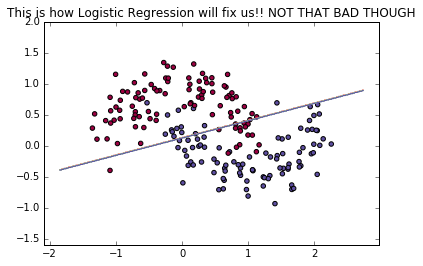

In [33]:
plot_decion_boundary(lambda x: model.predict(x))
plt.title("This is how Logistic Regression will fix us!! NOT THAT BAD THOUGH")

As we observed, LR did us a great work though not satisfying one, below we will construct a simple neural network consist of 3 layers(input-hidden-output), since we only have 2 features our model then will consist 2 input nodes and ofcoarse 2 outputs as we have 2 classification groups (0 for A patients and 1 for B patients) if you are little familiar with ML you will understand softmax activation will serve us well in this task, if you are new please take a moment to study some basic theories of NN and ML

In [34]:
num_samples = len(X) # training dataset size
input_dim = 2
output_dim = 2

epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength 

In [35]:
# loss function definition
def calculate_loss(nn_model):
    W1, b1, W2, b2 = nn_model['W1'], nn_model['b1'], nn_model['W2'], nn_model['b2']
    # foward propagation for our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # loss
    correct = -np.log(probs[range(num_samples), y])
    loss = np.sum(correct)
    # regularization
    loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_samples * loss

In [36]:
# predict function
def predict(nn_model, x):
    W1, b1, W2, b2 = nn_model['W1'], nn_model['b1'], nn_model['W2'], nn_model['b2']
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [37]:
# Now time to build our model
def nn_model(nn_hdim, num_passes=20000, print_loss=False):
    # parameter initialization
    np.random.seed(0)
    W1 = np.random.randn(input_dim, nn_hdim) / np.sqrt(input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, output_dim))
    
    nn_model = {}
    
    for i in range(0, num_passes): # gradient descent in each batch
        # foward pg
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores/ np.sum(exp_scores, axis=1, keepdims=True)
        
        # back pg
        delta3 = probs
        delta3[range(num_samples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)
        
        # regularizing
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        #parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign updated parameters to the model
        nn_model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # let's print loss after some iterations
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(nn_model)))
    return nn_model


Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068926
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


/home/daudi/anaconda3/envs/py5/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/daudi/anaconda3/envs/py5/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


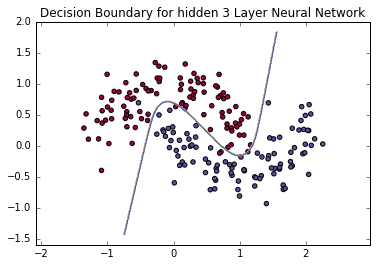

In [38]:
model = nn_model(3, print_loss=True)
plot_decion_boundary(lambda x: predict (model, x))
plt.title("Decision Boundary for hidden 3 Layer Neural Network")

Wouh! that was better is'nt it?? Well, we can play with parameters such as number of hidden layers, learning parameters to improve our model. In the above we used 3 hidden layer network, let's try several hidden layer dimensions

/home/daudi/anaconda3/envs/py5/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/daudi/anaconda3/envs/py5/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


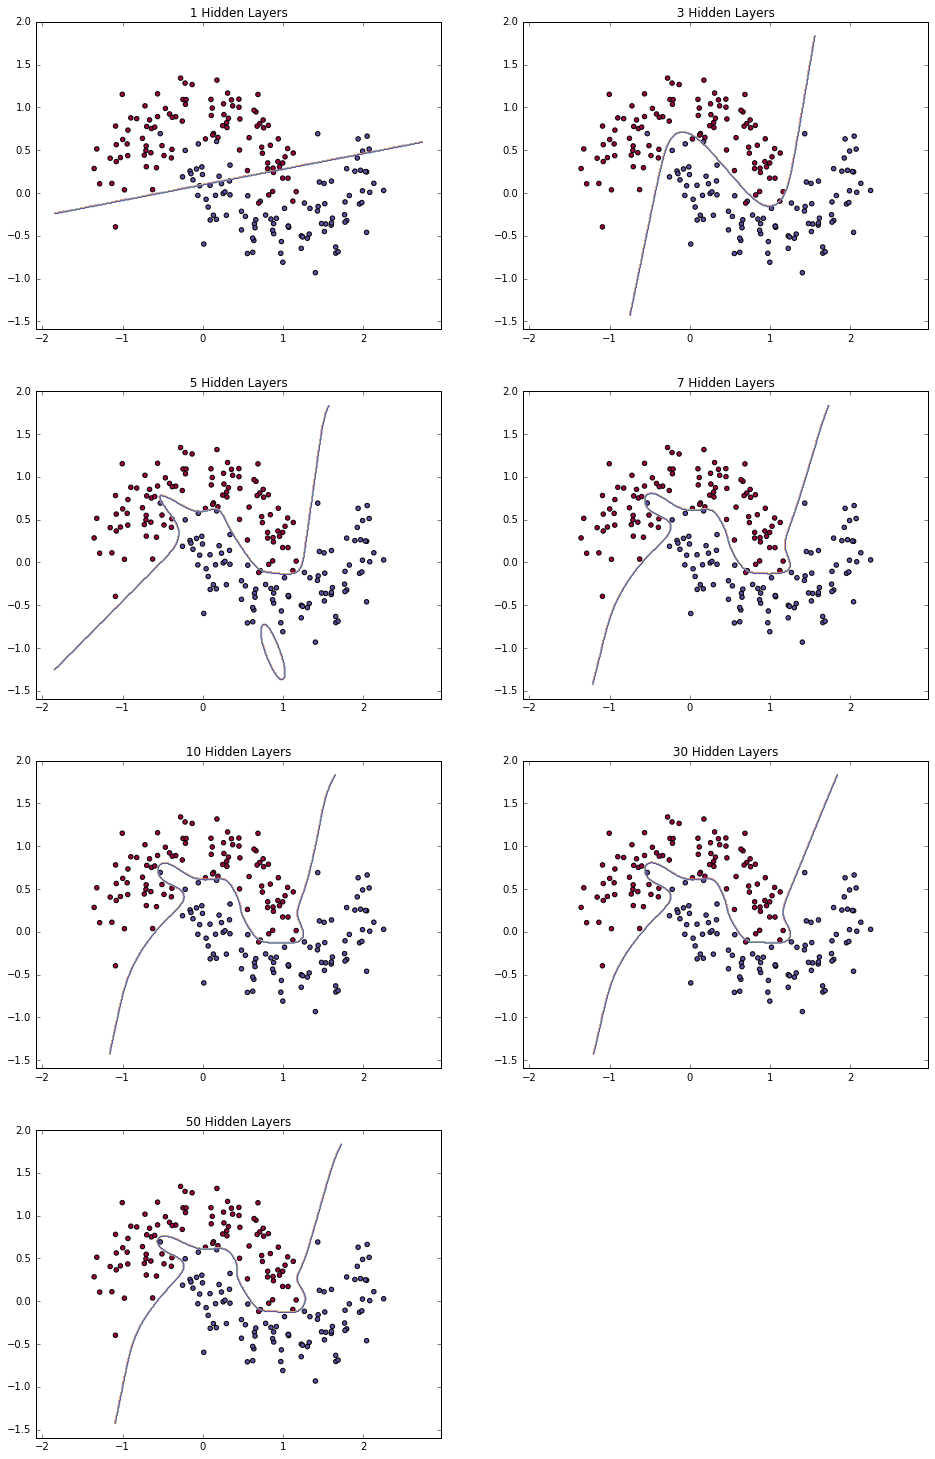

In [39]:
plt.figure(figsize=(16,32))
number_of_hidden_layers = [1,3,5,7,10,30,50]
for i, nn_hdim in enumerate(number_of_hidden_layers):
    plt.subplot(5, 2, i+1)
    plt.title(" %d Hidden Layers " %nn_hdim)
    model = nn_model(nn_hdim)
    plot_decion_boundary(lambda x: predict(model, x))